In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [2]:
place_list = [('Jharkhand', None), ('Jharkhand', 'Bokaro'), ('Jharkhand', 'Dhanbad'), ('Jharkhand', 'East Singhbhum')]

In [3]:
config_filename = 'dhanbad.yaml'
config = read_config(config_filename)

RUNNING ONCALL 1 FOR Jharkhand - None
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_30102020_tracker.pkl
splitting data ..
splitting data ..
          date      state   total  active  recovered  deceased     tested  \
0   2020-04-26  Jharkhand      82      66         13         3     7806.0   
1   2020-04-27  Jharkhand     103      83         17         3     8757.0   
2   2020-04-28  Jharkhand     105      83         19         3     9408.0   
3   2020-04-29  Jharkhand     107      85         19         3    10268.0   
4   2020-04-30  Jharkhand     110      88         19         3    10987.0   
..         ...        ...     ...     ...        ...       ...        ...   
183 2020-10-26  Jharkhand   99906    5666      93368       872  3126794.0   
184 2020-10-27  Jharkhand  100224    5474      93874       876  3152647.0   
185 2020-10-28  Jharkhand  100569    5363      94326       880  3193717.0   
186 2020-10-29  Jharkhand  100964    5294      94787       883  323352


getting forecasts ..
10it [00:00, 94.19it/s]getting forecasts ..
20it [00:00, 93.86it/s]
9it [00:00, 88.77it/s]getting forecasts ..
20it [00:00, 89.02it/s]
100%|██████████| 100/100 [00:01<00:00, 60.30trial/s, best loss: 32.575329024768216]
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
DONE WITH ONCALL 1
RUNNING ONCALL 2 FOR Jharkhand - None
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_30102020_tracker.pkl
splitting data ..
splitting data ..
          date      state   total  active  recovered  deceased     tested  \
0   2020-04-26  Jharkhand      82      66         13         3     7806.0   
1   2020-04-27  Jharkhand     103      83         17         3     8757.0   
2   2020-04-28  Jharkhand     105      83         19         3     9408.0   
3   2020-04-29  Jharkhand     107      85         19         3    10268.0   
4   2020-04-30  Jharkhand     110      88         19         3    109


getting forecasts ..
9it [00:00, 88.28it/s]getting forecasts ..
20it [00:00, 87.20it/s]
9it [00:00, 87.63it/s]getting forecasts ..
20it [00:00, 92.05it/s]
100%|██████████| 100/100 [00:01<00:00, 54.62trial/s, best loss: 26.95087334853386]
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
DONE WITH ONCALL 2


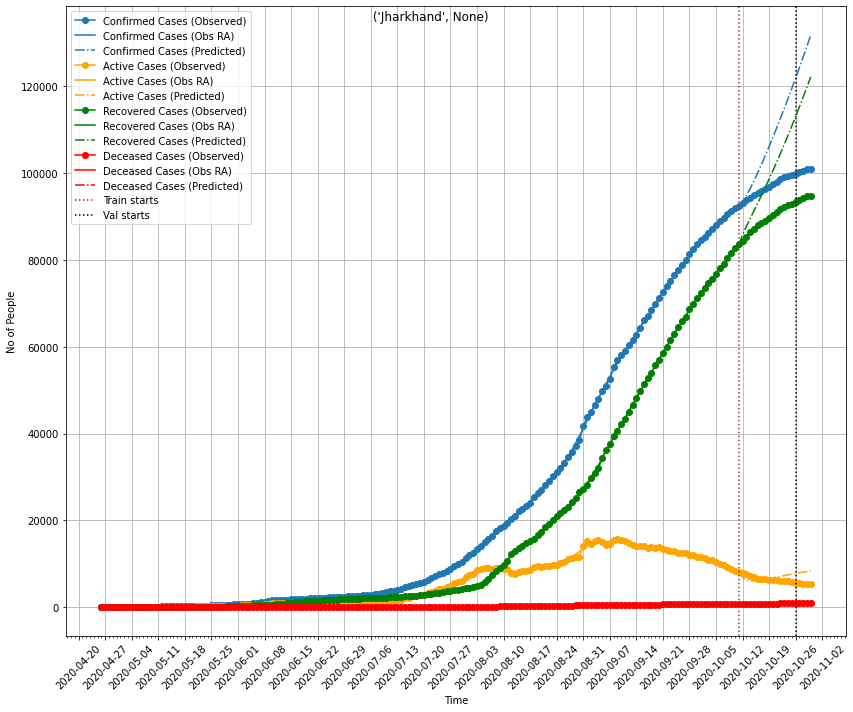

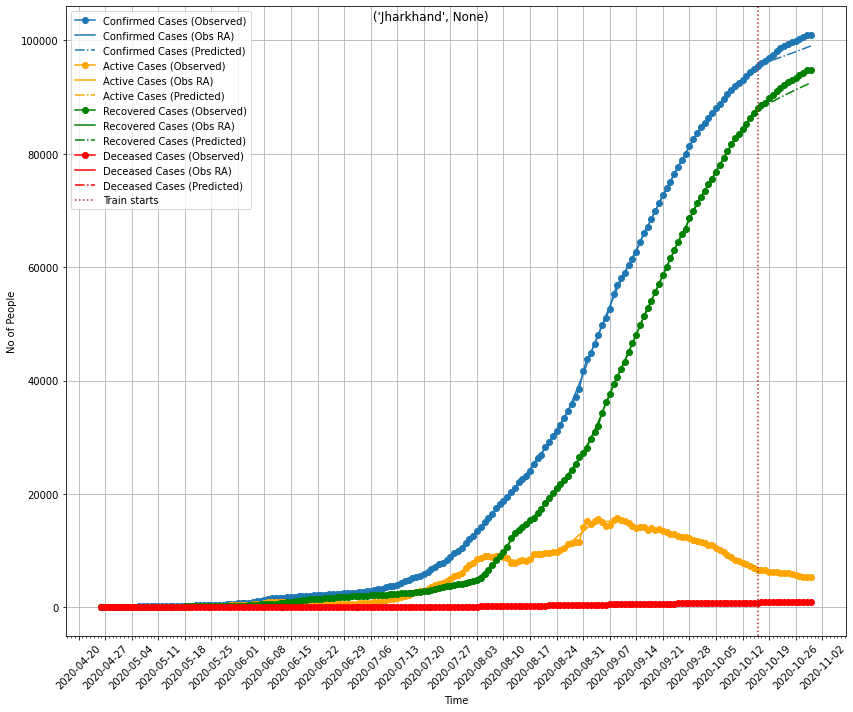

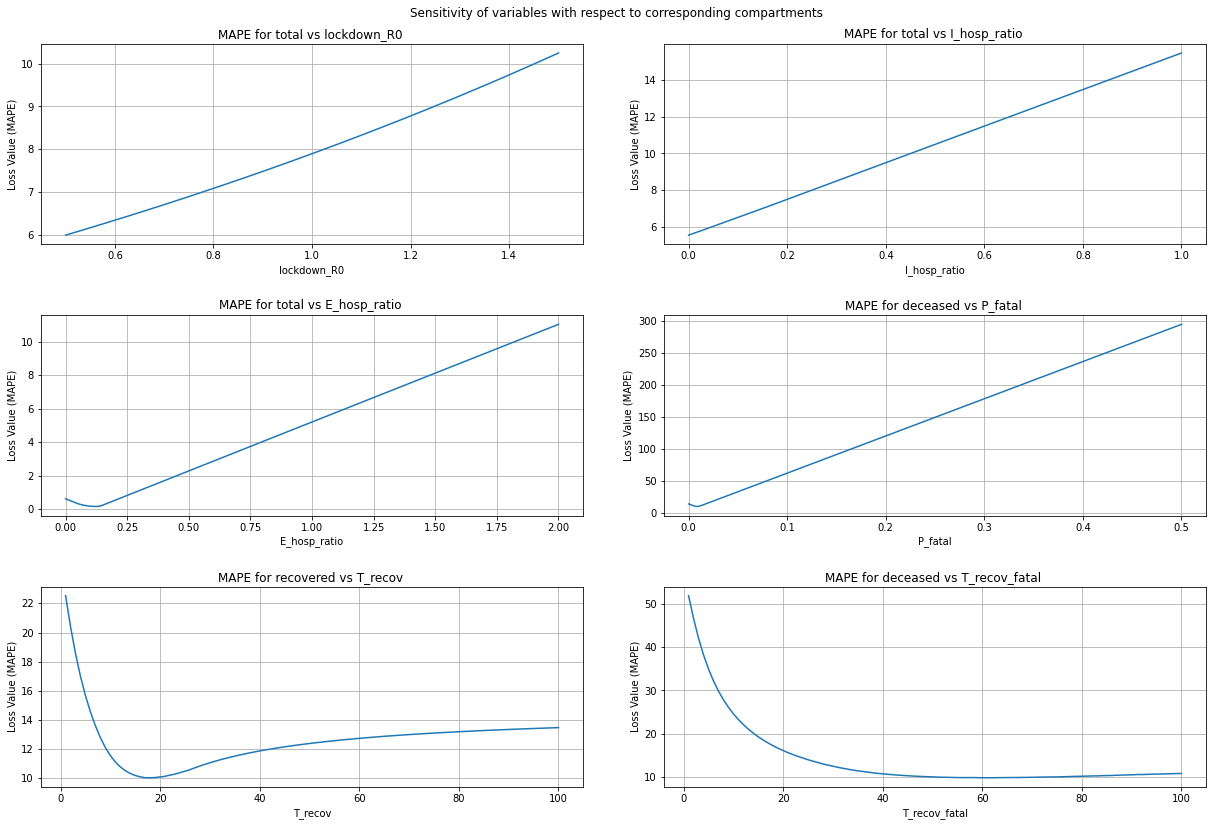

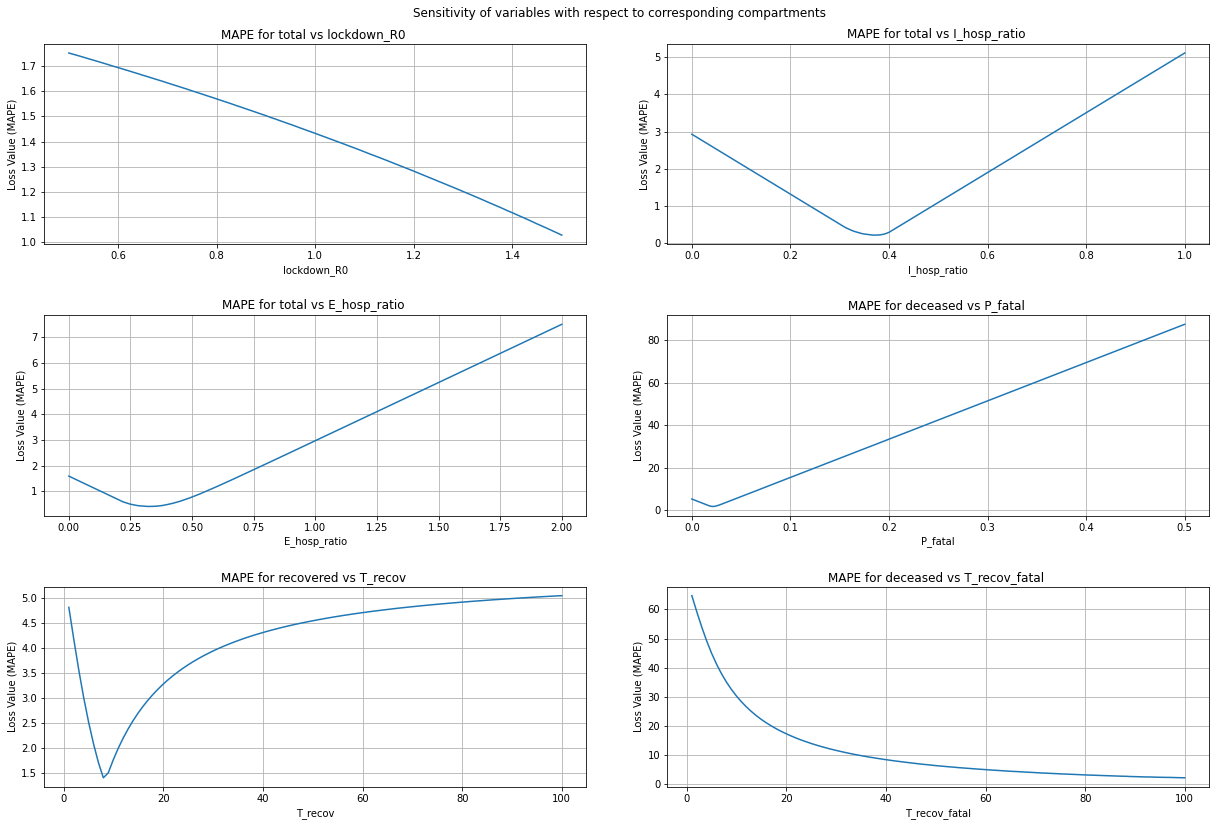

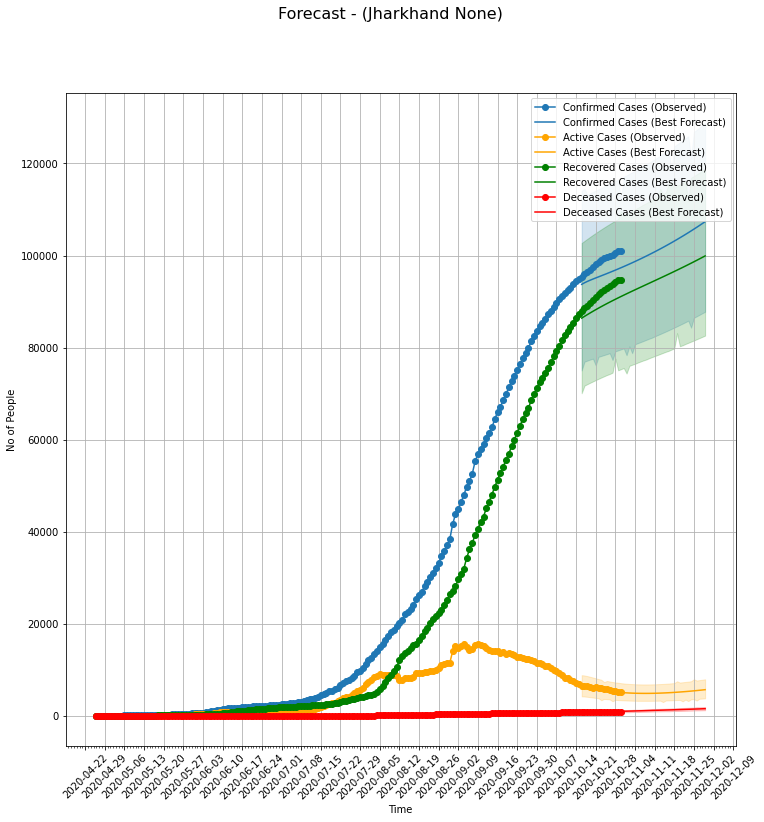

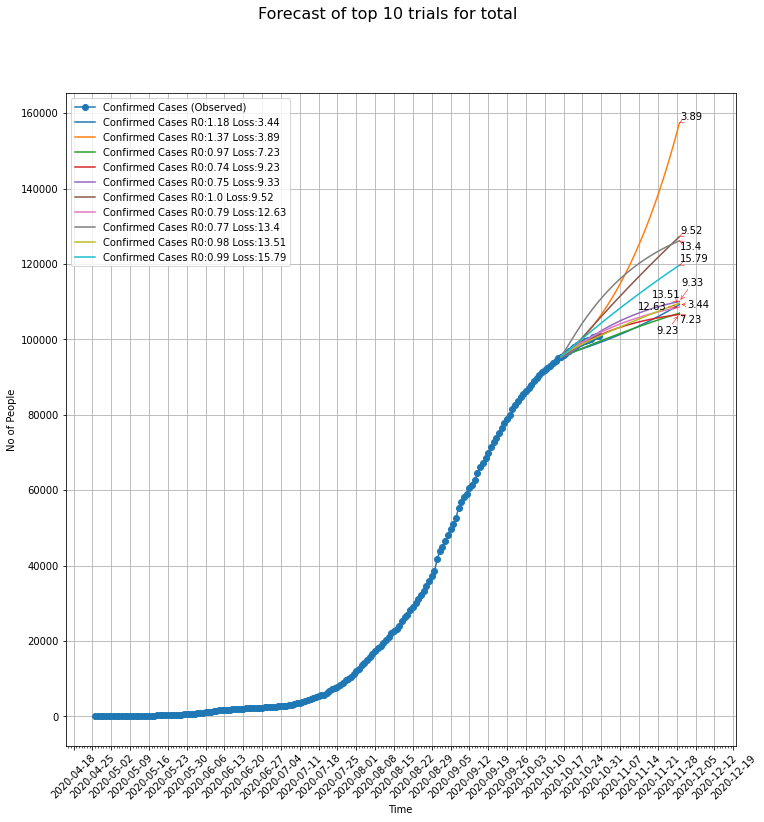

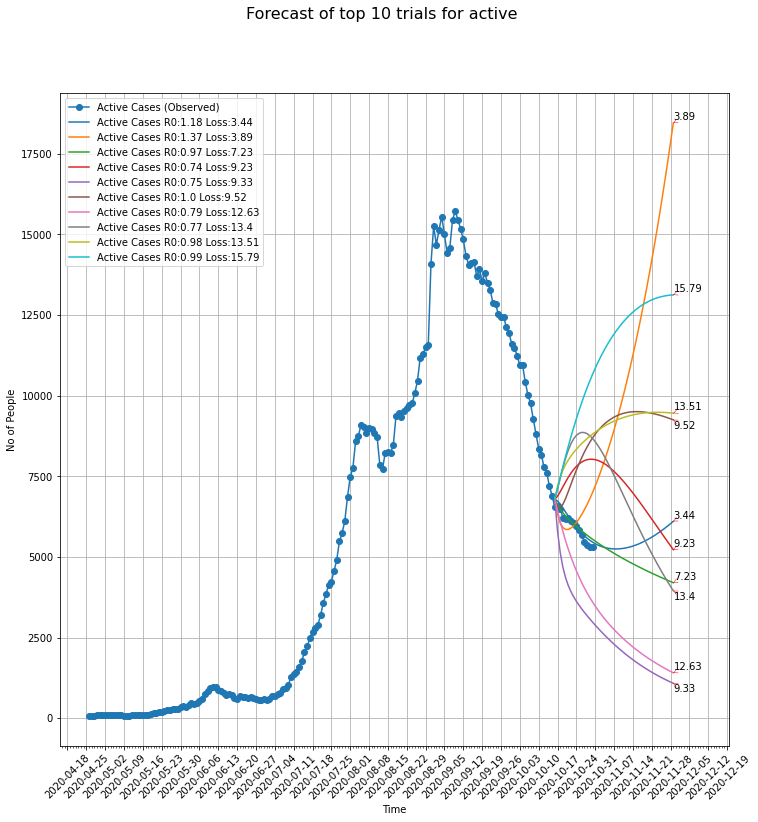

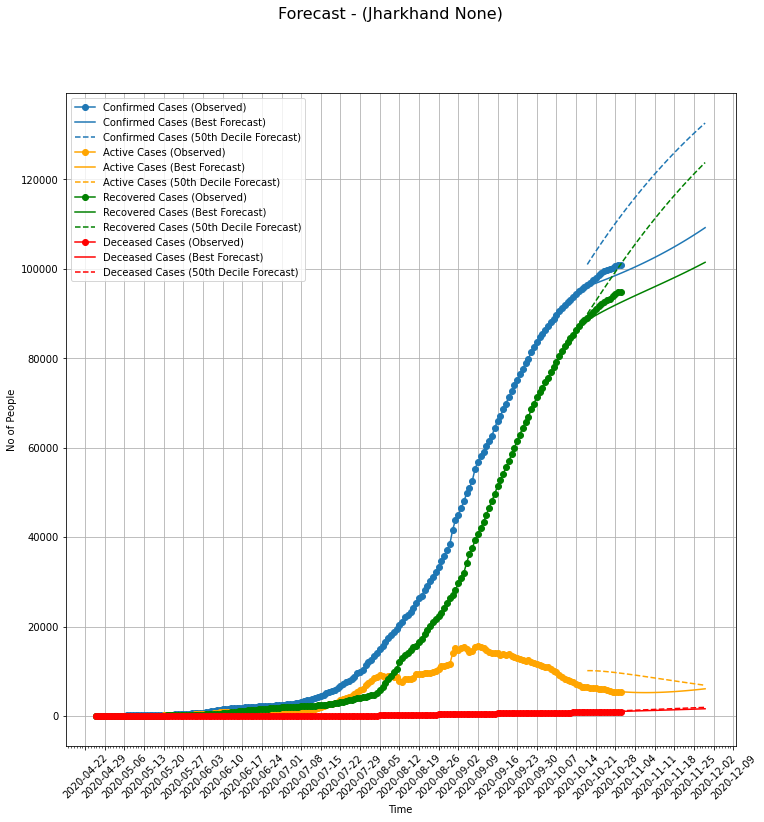

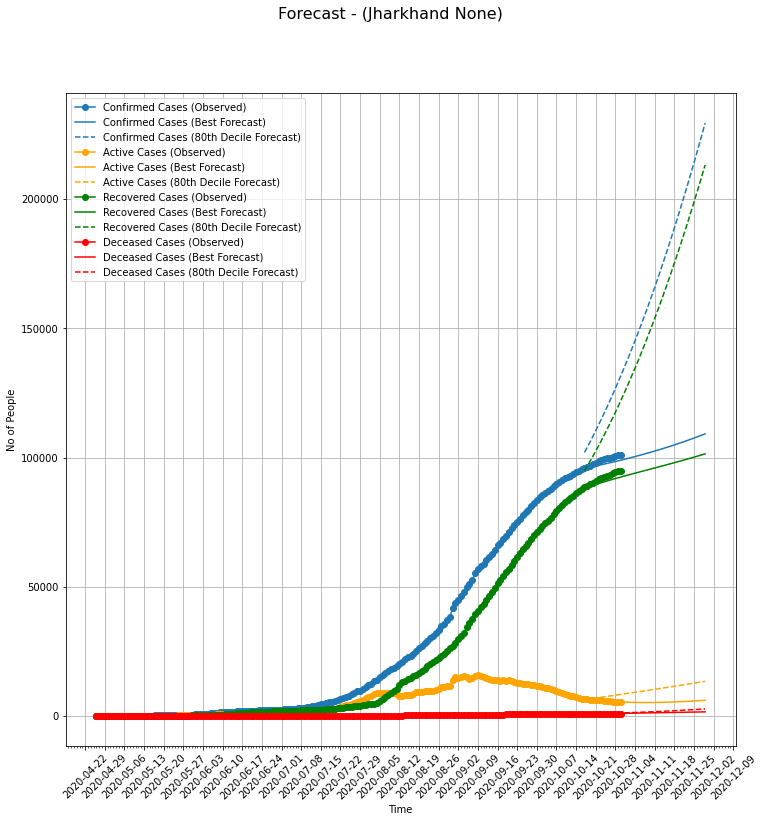

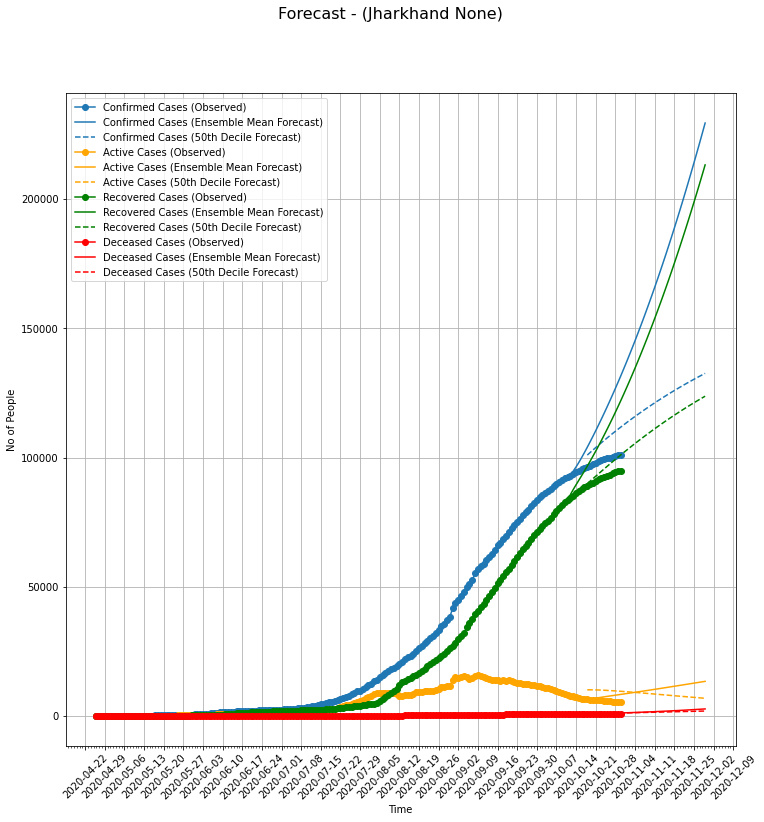

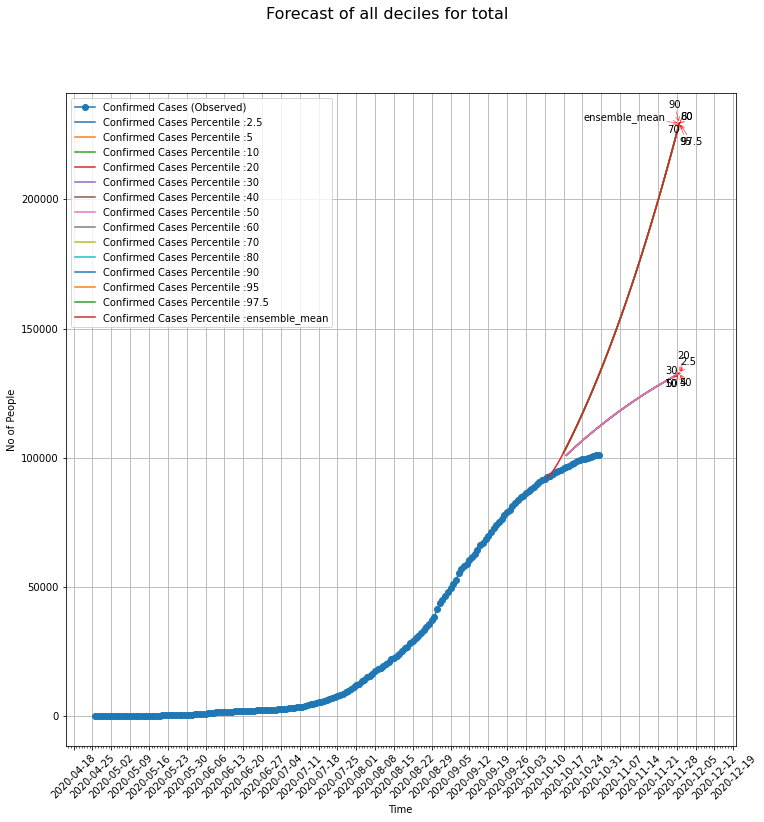

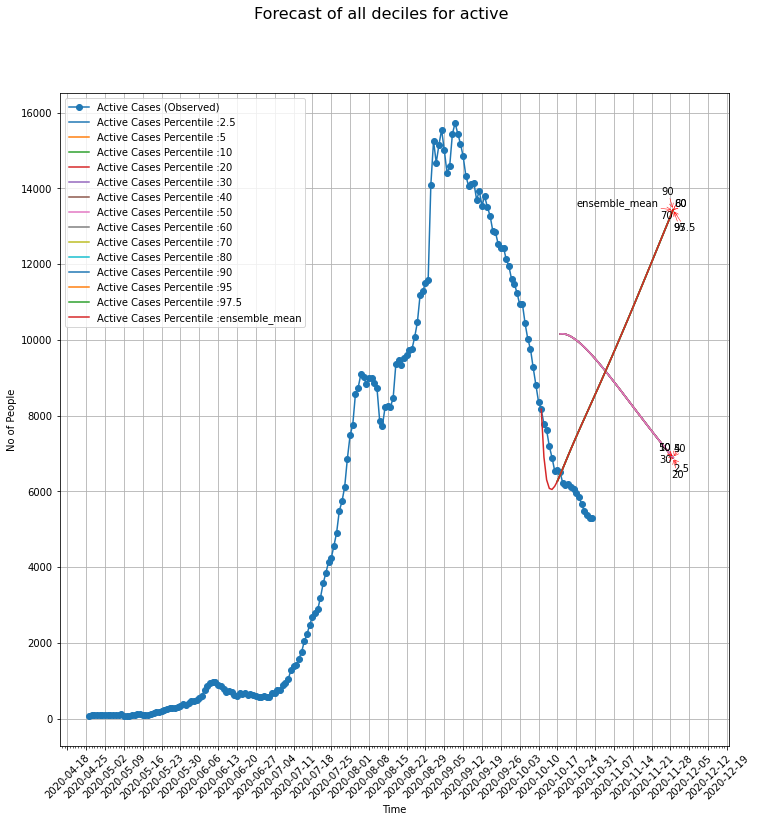

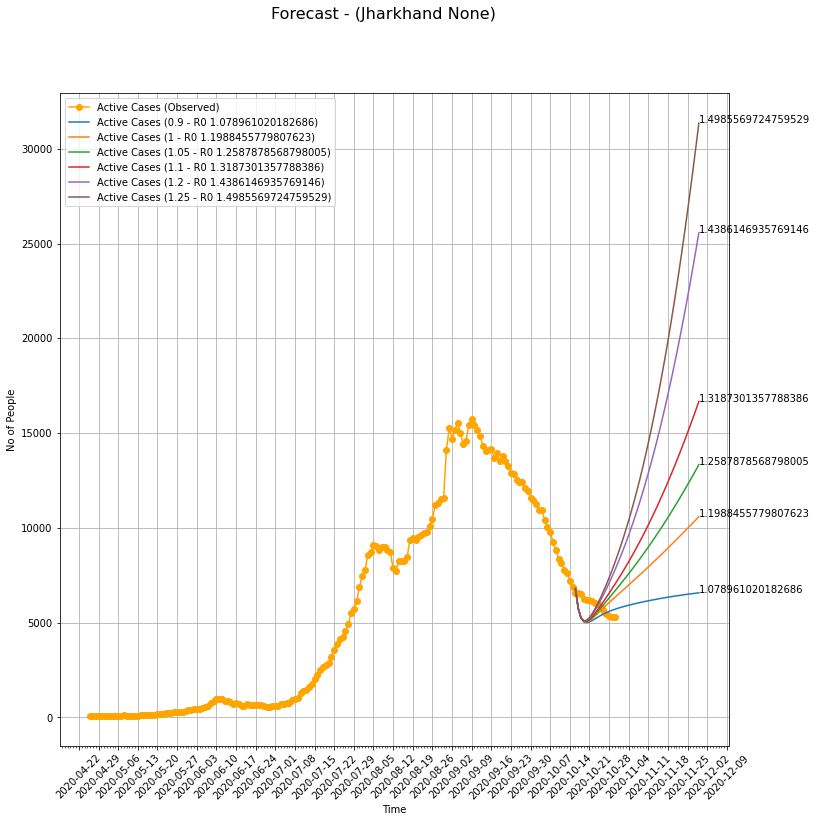

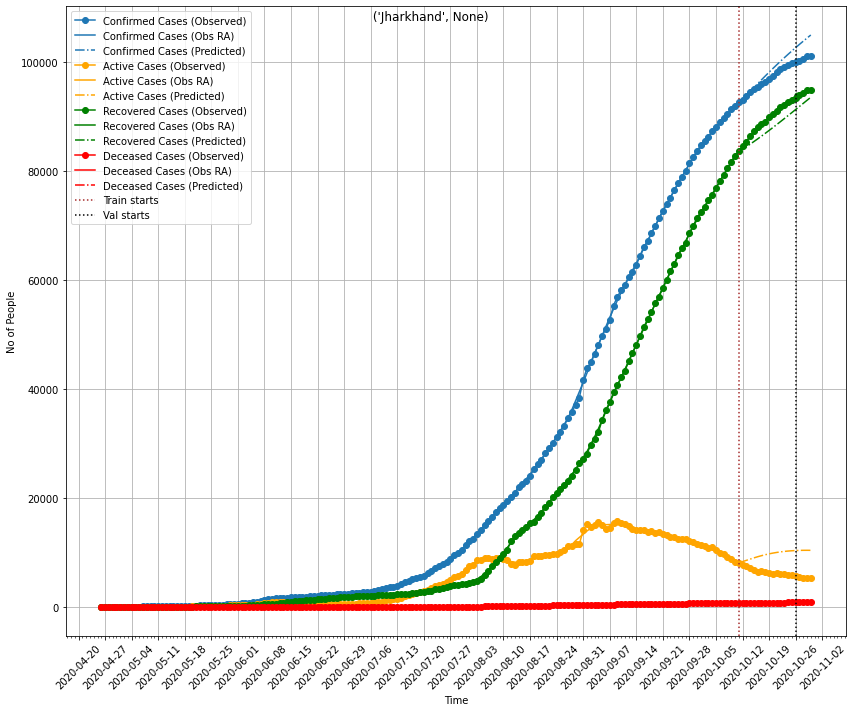

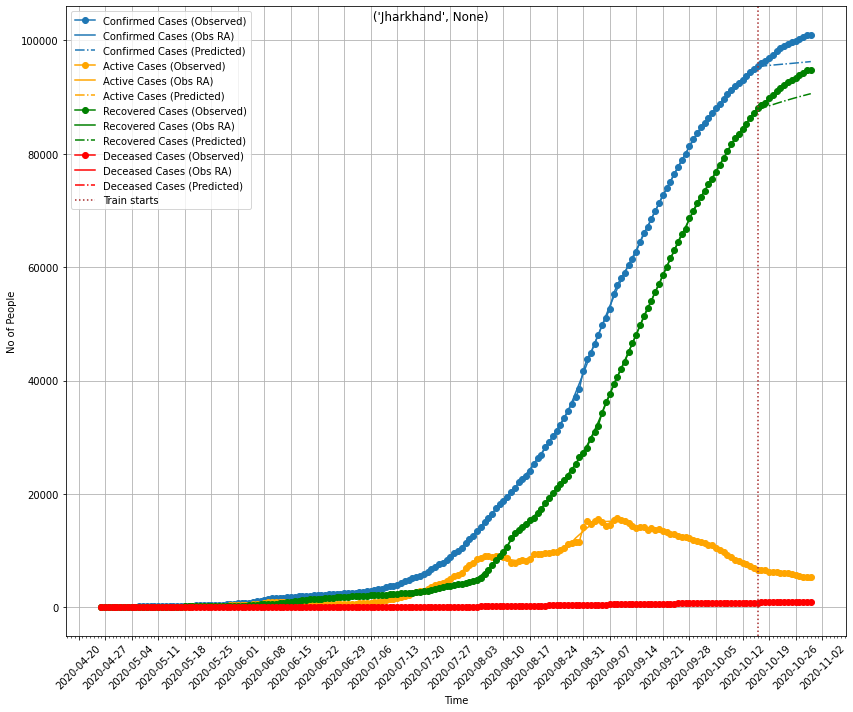

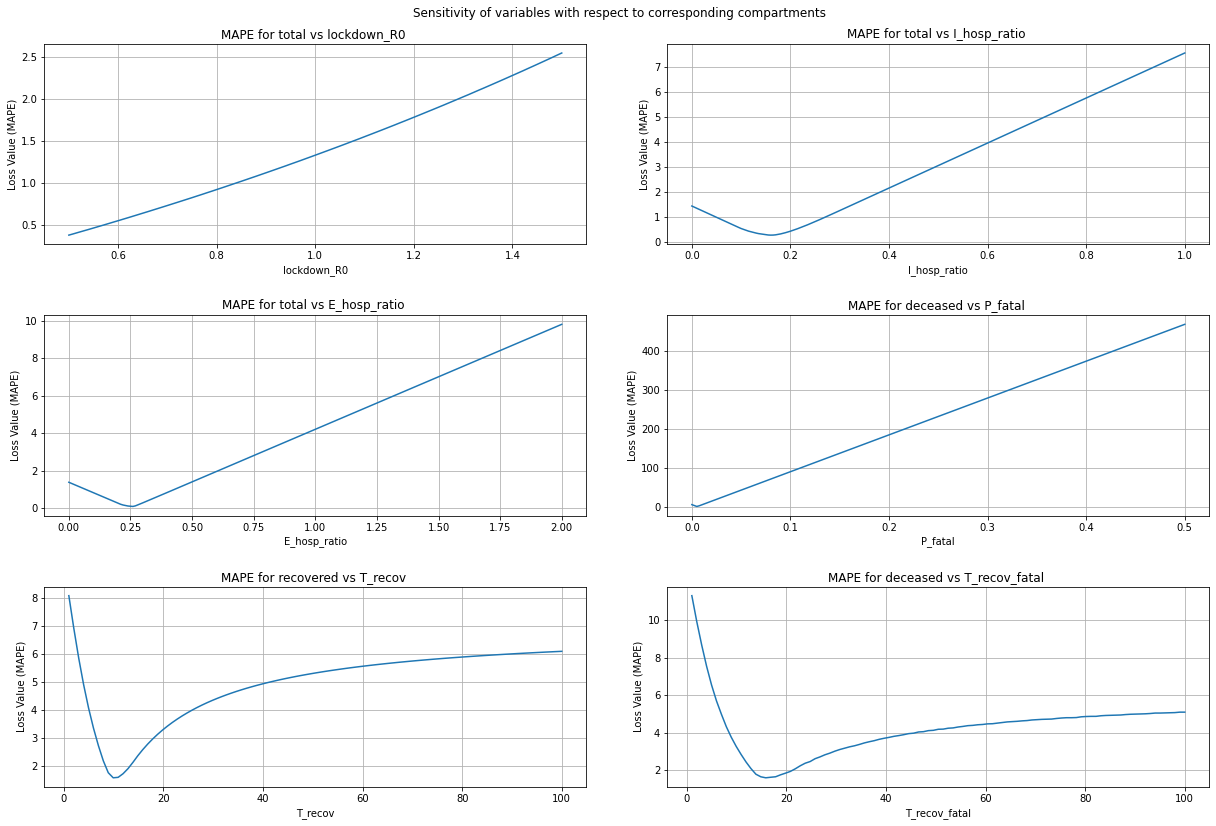

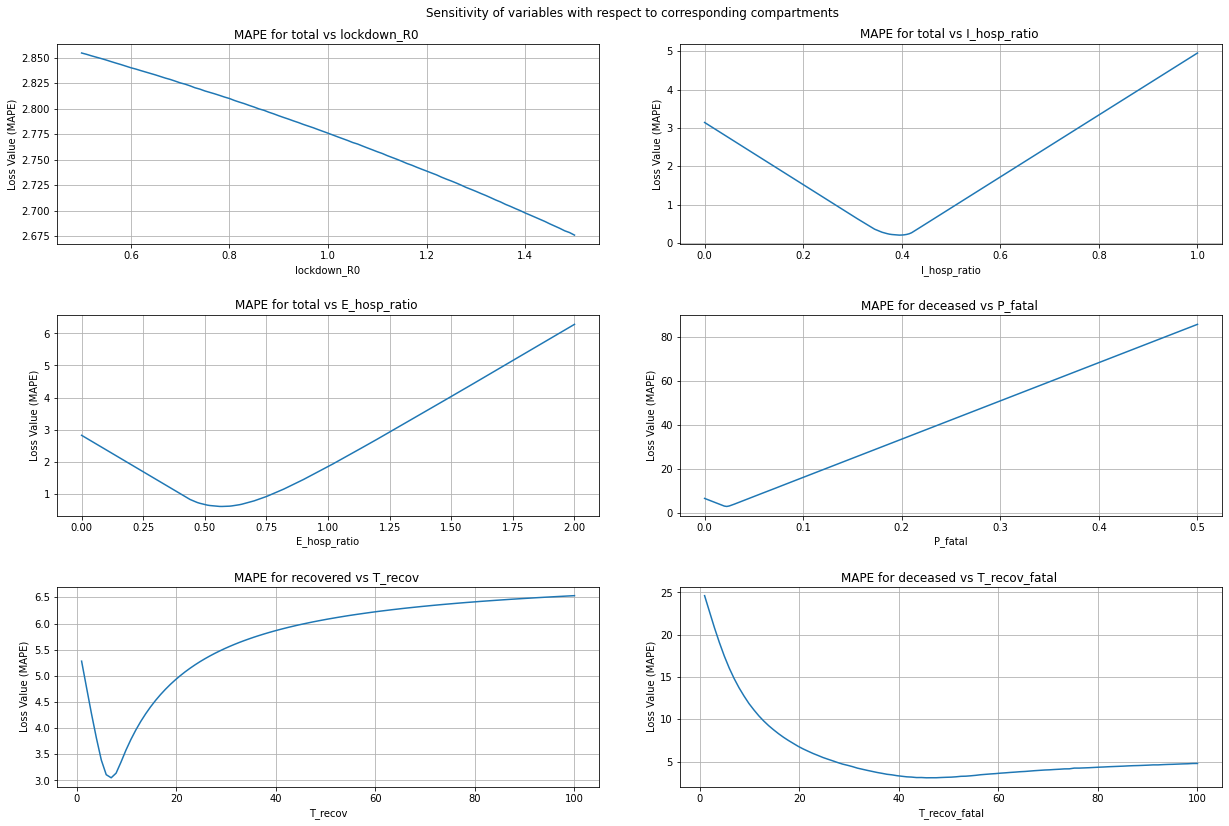

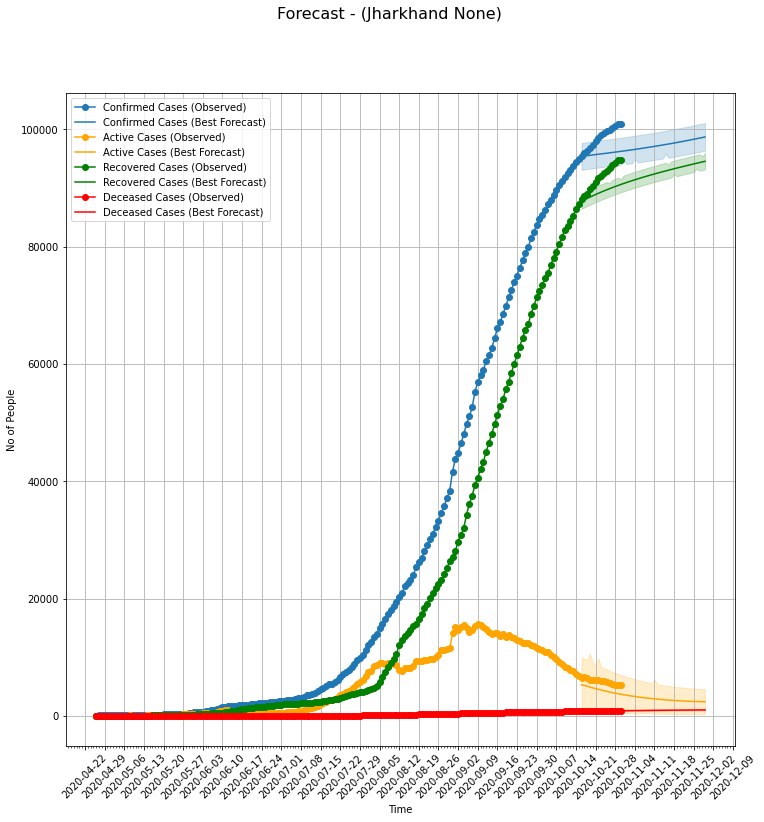

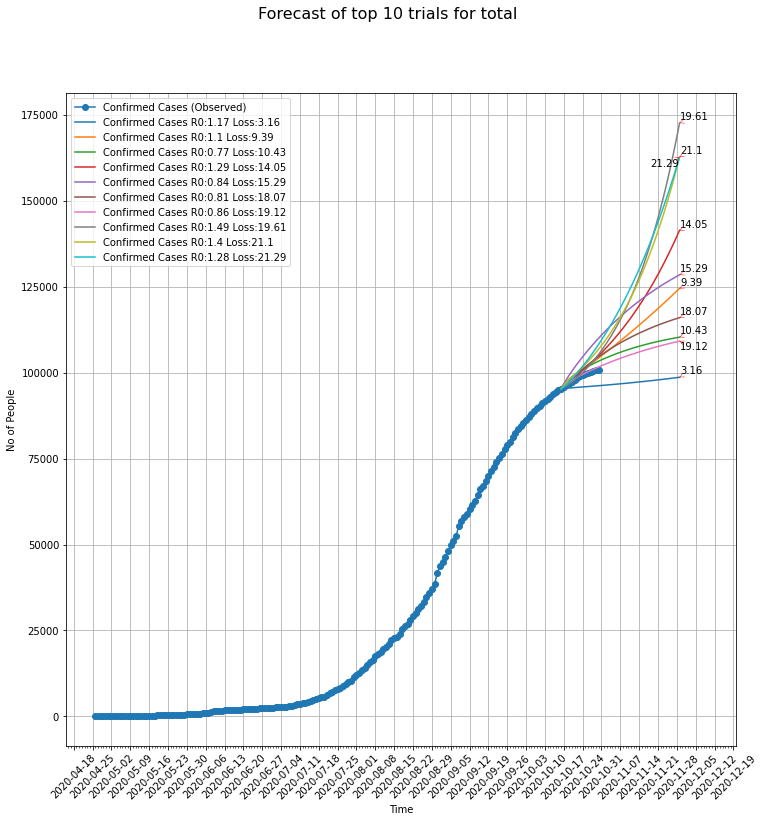

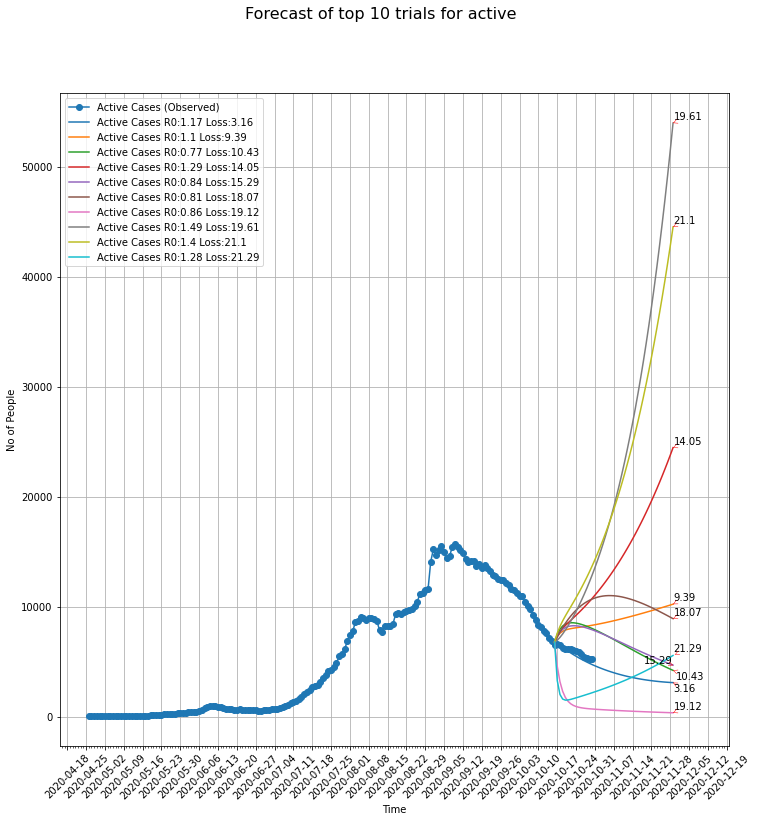

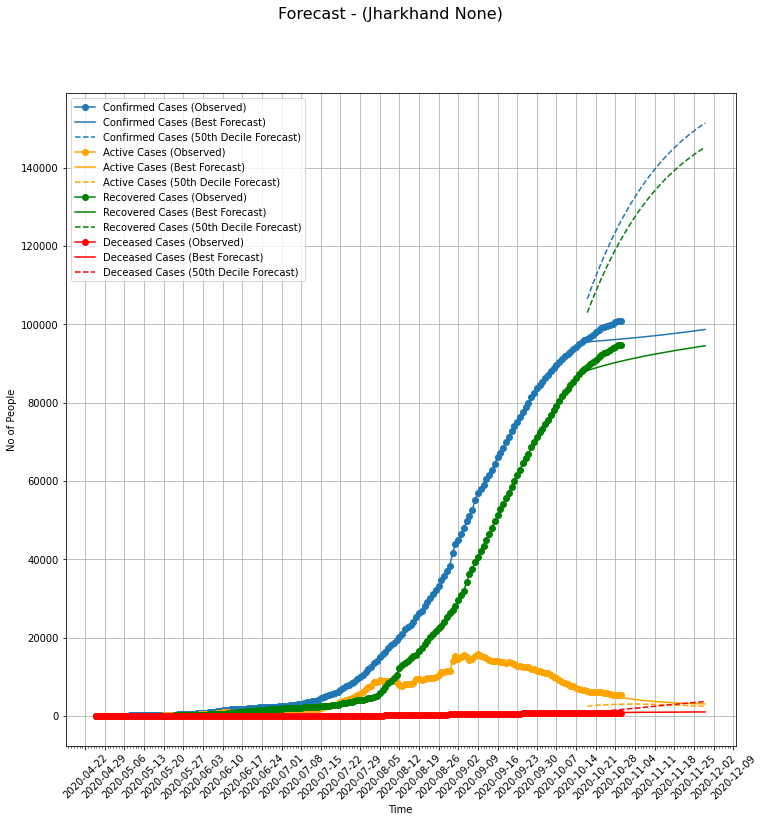

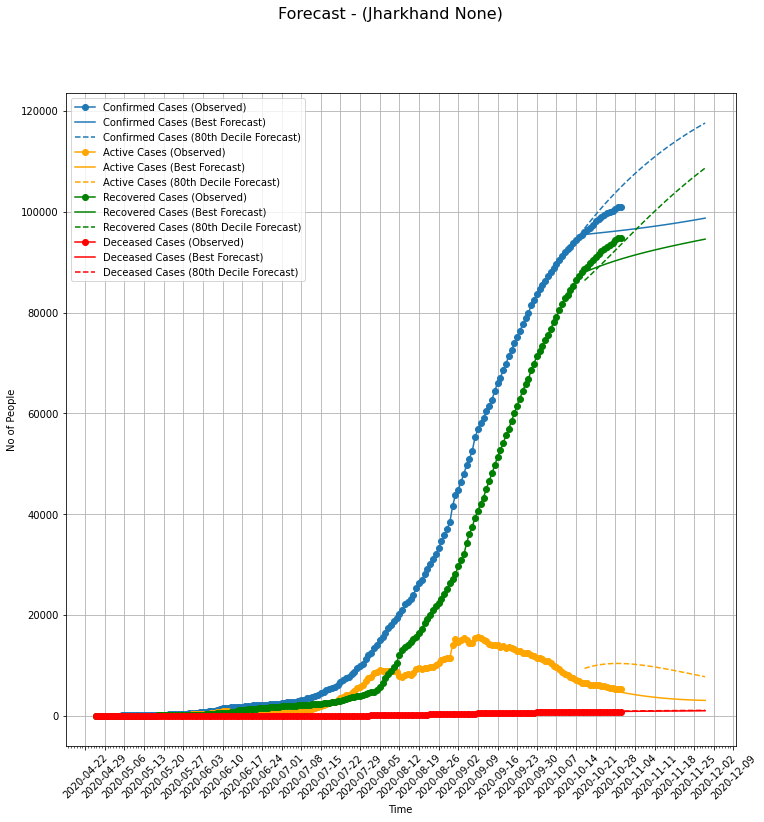

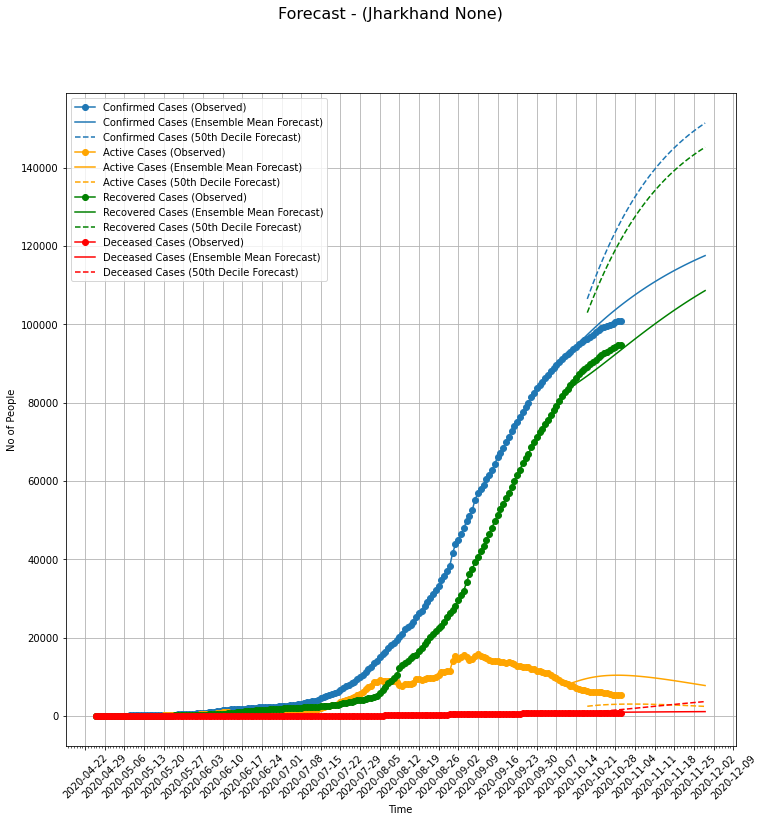

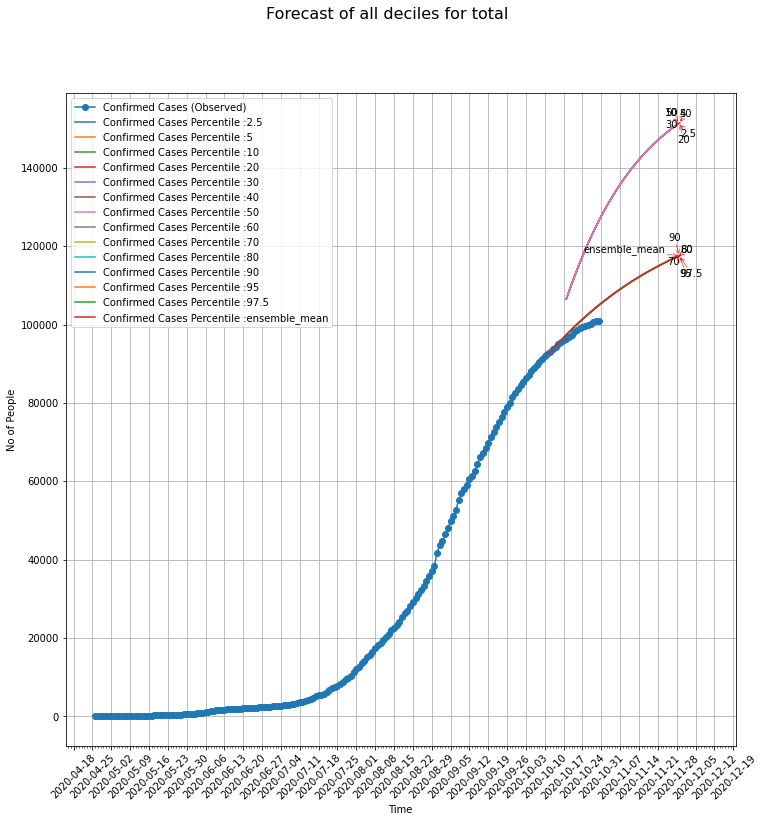

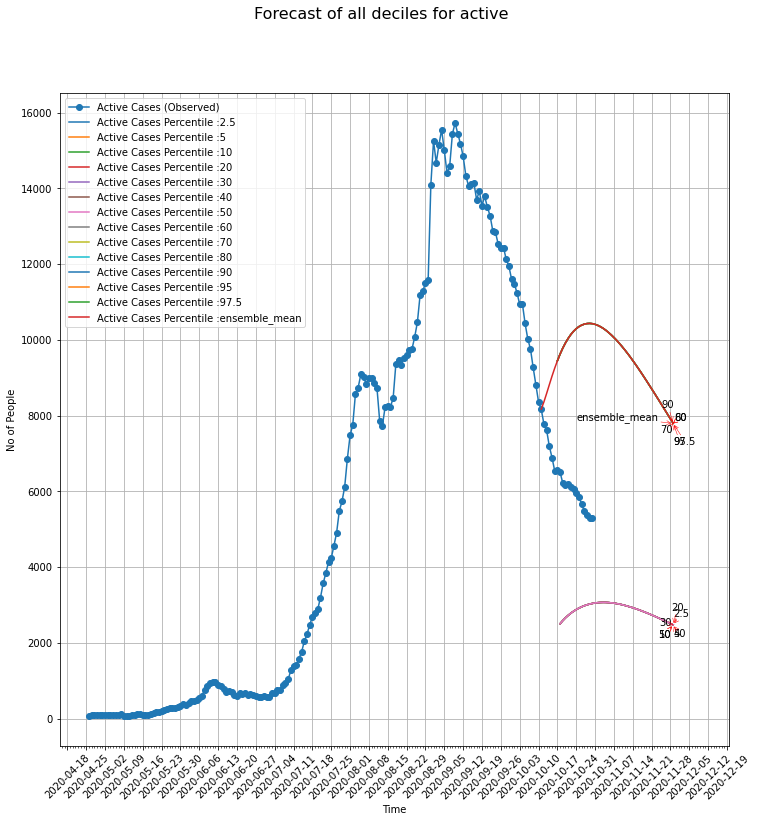

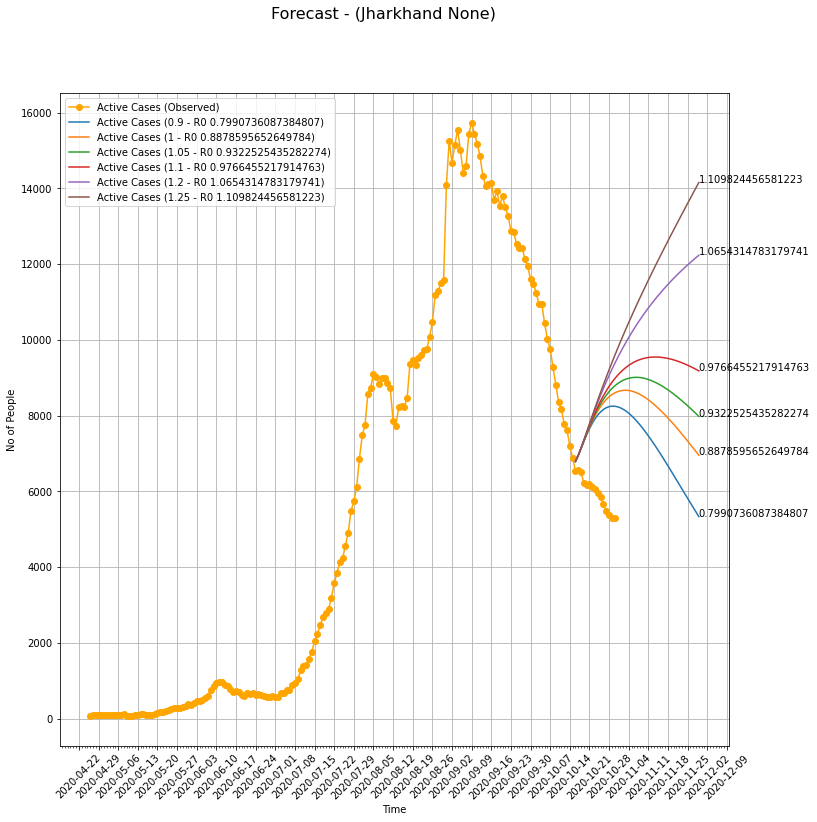

In [4]:
for i, place in enumerate(place_list):

    # READING THE DEFAULT CONFIG FILE
    config_filename = 'dhanbad.yaml'
    config = read_config(config_filename)
    
    state, district = place
    config['fitting']['data']['dataloading_params']['state'] = state
    config['fitting']['data']['dataloading_params']['district'] = district
    
    print("RUNNING ONCALL {} FOR {} - {}".format(i + 1, state, district))

    predictions_dict = {}

    output_folder = '../../misc/reports/{}_{}-{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"), state, district)

    predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

    m2_params = copy.deepcopy(config['fitting'])
    m2_params['split']['val_period'] = 0
    predictions_dict['m2'] = single_fitting_cycle(**m2_params)

    predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

    predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config,                         which_fit='m1')
    predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config,                         which_fit='m2')
    
    # M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
    predictions_dict['m2']['forecasts'] = {}
    predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                               model=config['fitting']['model'], 
                                                               days=config['forecast']['forecast_days'])
    # Predictions plotted are for the most recent train_period days + test_period + forecast_period (no            validation_period)
    predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict,
                (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']       ['dataloading_params']['district']),
                error_bars=True)

    predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

    

    predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])



    kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                                    k=config['forecast']['num_trials_to_plot'],
                                    which_compartments=config['forecast']['plot_topk_trials_for_columns'])



    predictions_dict['m2']['plots']['forecasts_topk'] = {}

    for column in config['forecast']['plot_topk_trials_for_columns']:
        predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]



    uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
    uncertainty = config['uncertainty']['method'](**uncertainty_args)



    uncertainty_forecasts = uncertainty.get_forecasts()
    for key in uncertainty_forecasts.keys():
        predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
    predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast 



    predictions_dict['m2']['beta'] = uncertainty.beta
    predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
    predictions_dict['m2']['deciles'] = uncertainty_forecasts  



    predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                       (config['fitting']['data']['dataloading_params']['state'], 
                                                                       config['fitting']['data']['dataloading_params']['district']),
                                                                       fits_to_plot=['best', 50], error_bars=False)
    predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                        (config['fitting']['data']['dataloading_params']['state'], 
                                                                        config['fitting']['data']['dataloading_params']['district']),
                                                                        fits_to_plot=['best', 80], error_bars=False)
    predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                              fits_to_plot=['ensemble_mean', 50], error_bars=False)



    ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
    predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
    for column in config['forecast']['plot_ptiles_for_columns']:
        predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

    

    r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
    predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'], days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
    predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])



    save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)



    df_output = create_decile_csv_new(predictions_dict)
    df_output.to_csv(f'{output_folder}/deciles.csv')



    df_all = create_all_trials_csv(predictions_dict)
    df_all.to_csv(f'{output_folder}/all_trials.csv')



    save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)



    predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')   


    print('DONE WITH ONCALL {}'.format(i + 1)) 